# DenoiSeg Example: Fly Wing
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a membrane labeled developing Fly Wing dataset from our collaborators. We already split the data into train and test images. From the train images we then extracted 1428 training and 252 validation patches of size 128x128. The test set contains 50 images of size 512x512.

In [3]:
import os
import sys

sys.path.append('/home/igor.zubarev/projects/DenoiSeg')
print(sys.executable)
print(os.getcwd())
import denoiseg
print('ok')

/home/igor.zubarev/miniconda3/envs/denoiSeg/bin/python
/home/igor.zubarev
ok


In [4]:
# Here we are just importing some libraries which are needed to run this notebook.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [5]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n20'

In [6]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://zenodo.org/record/5156991/files/Flywing_n0.zip?download=1'
elif noise_level == 'n10':
    link = 'https://zenodo.org/record/5156993/files/Flywing_n10.zip?download=1'
elif noise_level == 'n20':
    link = 'https://zenodo.org/record/5156995/files/Flywing_n20.zip?download=1'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/Flywing_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [7]:
# Loading of the training images
trainval_data =  np.load('data/Flywing_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [8]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (1428, 128, 128)
Shape of train_masks:  (1428, 128, 128)
Shape of val_images:   (252, 128, 128)
Shape of val_masks:    (252, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenario by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [9]:
# Set the number of annotated training images.
# Values: 0.0 (no annotated images) to total number of training images (all images have annotations)
number_of_annotated_training_images = 5
assert number_of_annotated_training_images >= 0.0 and number_of_annotated_training_images <=train_images.shape[0]

In [10]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)

# Here we convert the number of annotated images to be used for training as percentage of available training data.
percentage_of_annotated_training_images = float((number_of_annotated_training_images/train_images.shape[0]) * 100.0)
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <= 100.0

# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction=percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]

Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (11424, 128, 128)
Mask size after augmentation (11424, 128, 128)
Shape of X:     (11424, 128, 128, 1)
Shape of Y:     (11424, 128, 128, 3)
Shape of X_val: (252, 128, 128, 1)
Shape of Y_val: (252, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

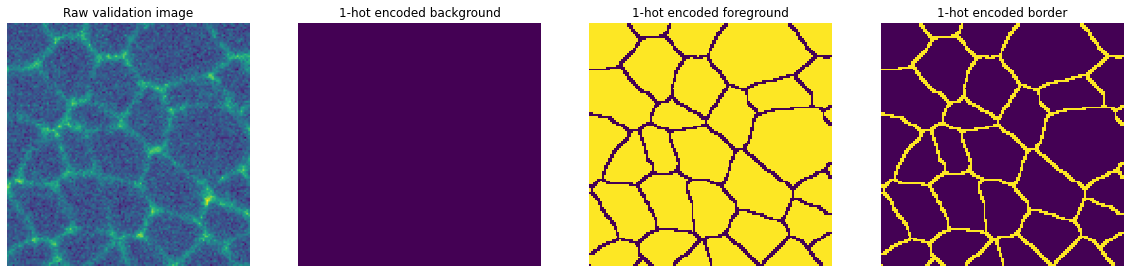

In [11]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

## Configure network parameters

In [12]:
train_batch_size = 128
train_steps_per_epoch = min(400, max(int(X.shape[0]/train_batch_size), 10))

In the next cell, you can choose how much relative importance (weight) to assign to denoising
and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [13]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=10,
                      batch_norm=True, train_batch_size=train_batch_size, unet_n_first=32,
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['44.541283'],
 'stds': ['43.985752'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 10,
 'train_steps_per_epoch': 89,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [14]:
model_name = 'DenoiSeg_Flywing_n20'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

2022-07-01 15:24:12.198401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-01 15:24:12.205362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 15:24:12.205537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GRID V100S-8Q computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 1.03TiB/s
2022-07-01 15:24:12.205565: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-01 15:24:12.215561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-01 15:24:12.215620: I tensorflow/stream_executor/platform/defaul

In [15]:
history = model.train(X, Y, (X_val, Y_val))

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 252/252 [00:01<00:00, 157.97it/s]
2022-07-01 15:24:16.251847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 15:24:16.252179: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399995000 Hz


Epoch 1/10


2022-07-01 15:24:18.318768: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-01 15:24:18.815911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-07-01 15:24:20.119132: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-01 15:24:20.562403: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


89/89 [==============================] - 30s 257ms/step - loss: 0.1758 - denoiseg: 0.1754 - seg_loss: 0.0028 - denoise_loss: 0.1726 - val_loss: 1.0977 - val_denoiseg: 1.0980 - val_seg_loss: 0.8116 - val_denoise_loss: 0.2864
Epoch 2/10
89/89 [==============================] - 20s 220ms/step - loss: 0.1309 - denoiseg: 0.1308 - seg_loss: 0.0022 - denoise_loss: 0.1286 - val_loss: 0.9184 - val_denoiseg: 0.9187 - val_seg_loss: 0.7115 - val_denoise_loss: 0.2072
Epoch 3/10
89/89 [==============================] - 20s 220ms/step - loss: 0.1278 - denoiseg: 0.1278 - seg_loss: 0.0019 - denoise_loss: 0.1259 - val_loss: 0.7779 - val_denoiseg: 0.7781 - val_seg_loss: 0.6228 - val_denoise_loss: 0.1553
Epoch 4/10
89/89 [==============================] - 20s 219ms/step - loss: 0.1264 - denoiseg: 0.1265 - seg_loss: 0.0019 - denoise_loss: 0.1246 - val_loss: 0.7138 - val_denoiseg: 0.7139 - val_seg_loss: 0.5806 - val_denoise_loss: 0.1333
Epoch 5/10
89/89 [==============================] - 20s 219ms/step - lo

In [16]:
history.history.keys()

dict_keys(['loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'lr'])

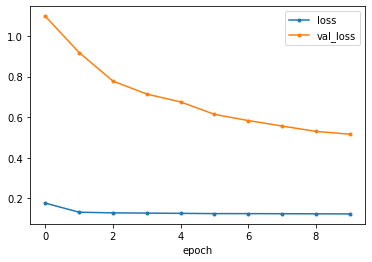

In [17]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [18]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), axes='YX')

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


  0%|          | 0/19 [00:00<?, ?it/s]

Score for threshold = 0.10 is 0.0187
Score for threshold = 0.15 is 0.0922
Score for threshold = 0.20 is 0.2640
Score for threshold = 0.25 is 0.4261
Score for threshold = 0.30 is 0.5173
Score for threshold = 0.35 is 0.5417
Score for threshold = 0.40 is 0.5433
Score for threshold = 0.45 is 0.5277
Score for threshold = 0.50 is 0.4994
Score for threshold = 0.55 is 0.4605
Score for threshold = 0.60 is 0.4121
Score for threshold = 0.65 is 0.3623
Score for threshold = 0.70 is 0.3085
Score for threshold = 0.75 is 0.2524
Score for threshold = 0.80 is 0.1880
Score for threshold = 0.85 is 0.1150
Score for threshold = 0.90 is 0.0461
Score for threshold = 0.95 is 0.0037
Score for threshold = 1.00 is 0.0000
The higest score of 0.543 is achieved with threshold = 0.4.


## Test Data
Finally we load the test data and run the prediction.

In [19]:
test_data =  np.load('data/Flywing_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [20]:
predicted_denoised, predicted_images, precision_result, _ = model.predict_denoised_label_masks(test_images,
                                                                                               test_masks,
                                                                                               axes='YX',
                                                                                               threshold=threshold,
                                                                                               measure=measure_precision())

print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

AttributeError: 'DenoiSeg' object has no attribute 'predict_label_masks'

### Visualize the results

In [ ]:
sl = 1
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.imshow(test_images[sl])
plt.title("Raw image")

plt.subplot(1, 4, 2)
plt.imshow(predicted_denoised[sl])
plt.title("Predicted denoised image")

plt.subplot(1, 4, 3)
plt.imshow(predicted_images[sl])
plt.title("Predicted foreground segmentation")

plt.subplot(1, 4, 4)
plt.imshow(test_masks[sl])
plt.title("Ground truth segmentation")

plt.show()

In [ ]:
print("Number of annotated images used for training:", number_of_annotated_training_images)
print("Noise level:", noise_level)
print("Considered alpha:", conf.denoiseg_alpha)

### Expected results for this dataset

<b>AP scores for Flywing n0 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.737±0.041|0.808±0.013|0.849±0.012|0.894±0.008|0.925±0.001|
|Alpha 0.3|0.772±0.030|0.786±0.040|0.838±0.028|0.912±0.003|0.919±0.004|
|Alpha 0.7|0.680±0.040|0.795±0.009|0.811±0.006|0.871±0.012|0.913±0.007|
|Alpha best|0.806±0.014|0.871±0.006|0.892±0.005|0.923±0.003|0.929±0.0008|

<b>AP scores for Flywing n10 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.782±0.026|0.855±0.008|0.874±0.012|0.891±0.009|0.898±0.012|
|Alpha 0.3|0.799±0.036|0.847±0.011|0.862±0.020|0.880±0.010|0.916±0.005|
|Alpha 0.7|0.736±0.046|0.801±0.027|0.862±0.011|0.894±0.005|0.907±0.007|
|Alpha best|0.857±0.010|0.878±0.010|0.893±0.005|0.919±0.003|0.929±0.0009|

<b>AP scores for Flywing n20 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.788±0.078|0.865±0.014|0.880±0.014|0.895±0.005|0.902±0.009|
|Alpha 0.3|0.848±0.019|0.868±0.014|0.878±0.011|0.913±0.004|0.916±0.005|
|Alpha 0.7|0.824±0.041|0.878±0.007|0.870±0.012|0.894±0.007|0.892±0.010|
|Alpha best|0.882±0.014|0.907±0.003|0.899±0.005|0.917±0.003|0.929±0.001|

### Export your model for Fiji

In [ ]:
model.export_TF(name='DenoiSeg - FlyWing Example', 
                description='This is the 2D DenoiSeg example trained on FlyWing data in python.', 
                authors=["Tim-Oliver Buchholz", "Mangal Prakash", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=(128, 128))